### Deep Latent Policy Gradient

In [1]:
import numpy as np
import torch
import torch.nn as nn  
import torch.nn.functional as F 
import matplotlib.pyplot as plt
from util import ikdpp,torch2np,np2torch
from dlpg import DeepLatentPolicyGradientClass
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("Torch version:[%s]"%(torch.__version__))

Torch version:[1.12.0.dev20220519]


### MNIST

In [2]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(
    root='../data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test  = datasets.MNIST(
    root='../data/',train=False,transform=transforms.ToTensor(),download=True)
# Training data
x_train_torch               = mnist_train.data.float().reshape(-1,784)/255.
y_train_torch               = mnist_train.targets
x_test_torch                = mnist_test.data.float().reshape(-1,784)/255.
y_test_torch                = mnist_test.targets
x_train_np,x_test_np        = torch2np(x_train_torch),torch2np(x_test_torch)
y_train_np,y_test_np        = torch2np(y_train_torch),torch2np(y_test_torch)
c_train_np,c_test_np        = np.eye(10,10)[y_train_np],np.eye(10,10)[y_test_np]
n_train,n_test              = x_train_np.shape[0],x_test_np.shape[0]
c_train_torch,c_test_torch  = np2torch(c_train_np),np2torch(c_test_np)
print ("x_train_np:%s x_test_np:%s"%(x_train_np.shape,x_test_np.shape,))
print ("c_train_np:%s c_test_np:%s"%(c_train_np.shape,c_test_np.shape,))
print ("n_train:[%d] n_test:[%d]"%(n_train,n_test))

x_train_np:(60000, 784) x_test_np:(10000, 784)
c_train_np:(60000, 10) c_test_np:(10000, 10)
n_train:[60000] n_test:[10000]


/opt/homebrew/Caskroom/miniforge/base/envs/torch-mac/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


### DLPG with MNIST
We assign $ q = 0.1 \times (x+1) - 0.5$ where $x \in [0,1,\ldots, 9]$ is the number of of the digit.

In [3]:
def q_func(q_in):
    q_out = 0.1*(q_in+1.0)-0.5
    return q_out*10
q_train_np,q_test_np       = q_func(y_train_np),q_func(y_test_np)
q_train_torch,q_test_torch = np2torch(q_train_np),np2torch(q_test_np)
print ("Done.")

Done.


### Unconditioned DLPG

[DLPG] instantiated
<bound method Module.parameters of DeepLatentPolicyGradientClass(
  (actv_enc): ReLU()
  (actv_dec): ReLU()
  (actv_q): Softplus(beta=1, threshold=20)
  (cvae_parameters): ParameterDict(
      (dec_00_lin_b): Parameter containing: [torch.FloatTensor of size 256]
      (dec_00_lin_w): Parameter containing: [torch.FloatTensor of size 256x2]
      (dec_01_lin_b): Parameter containing: [torch.FloatTensor of size 256]
      (dec_01_lin_w): Parameter containing: [torch.FloatTensor of size 256x256]
      (enc_00_lin_b): Parameter containing: [torch.FloatTensor of size 256]
      (enc_00_lin_w): Parameter containing: [torch.FloatTensor of size 256x784]
      (enc_01_lin_b): Parameter containing: [torch.FloatTensor of size 256]
      (enc_01_lin_w): Parameter containing: [torch.FloatTensor of size 256x256]
      (out_lin_b): Parameter containing: [torch.FloatTensor of size 784]
      (out_lin_w): Parameter containing: [torch.FloatTensor of size 784x256]
      (z_mu_lin_b): P

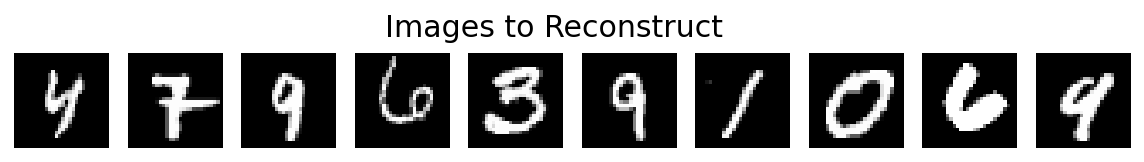

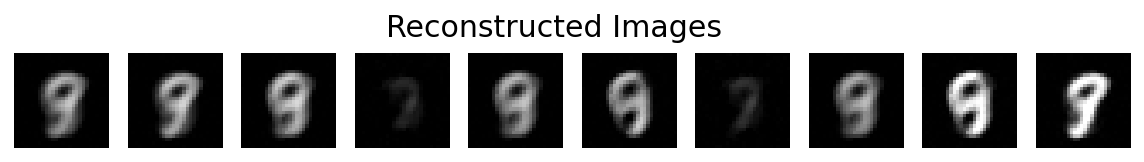

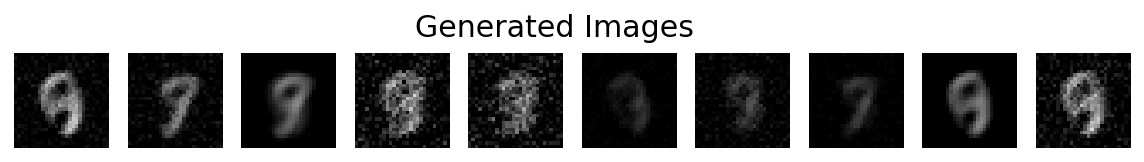

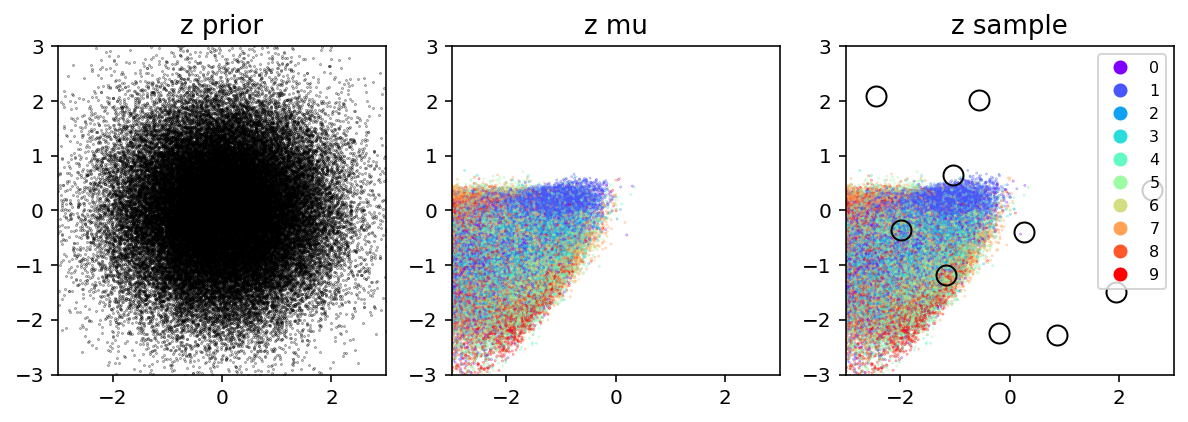

[5/100] total:[1.240] recon:[1.240] kl:[0.000]
[10/100] total:[1.178] recon:[1.178] kl:[0.000]
[15/100] total:[1.109] recon:[1.109] kl:[0.000]
[20/100] total:[1.097] recon:[1.069] kl:[0.028]
[25/100] total:[1.068] recon:[1.040] kl:[0.028]
[30/100] total:[1.052] recon:[1.019] kl:[0.033]
[35/100] total:[1.041] recon:[1.004] kl:[0.037]
[40/100] total:[1.034] recon:[0.992] kl:[0.042]
[45/100] total:[1.031] recon:[0.984] kl:[0.047]
[50/100] total:[1.027] recon:[0.976] kl:[0.051]


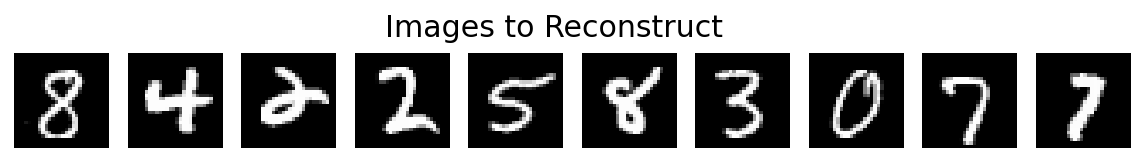

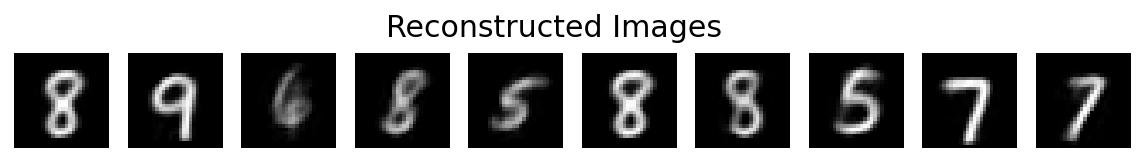

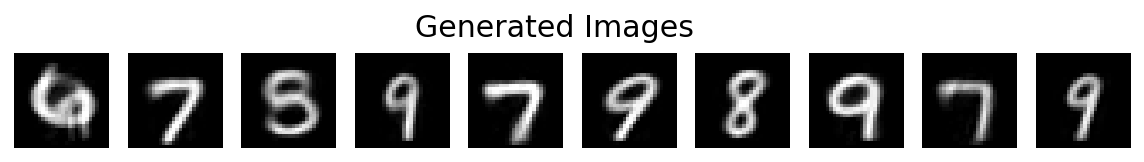

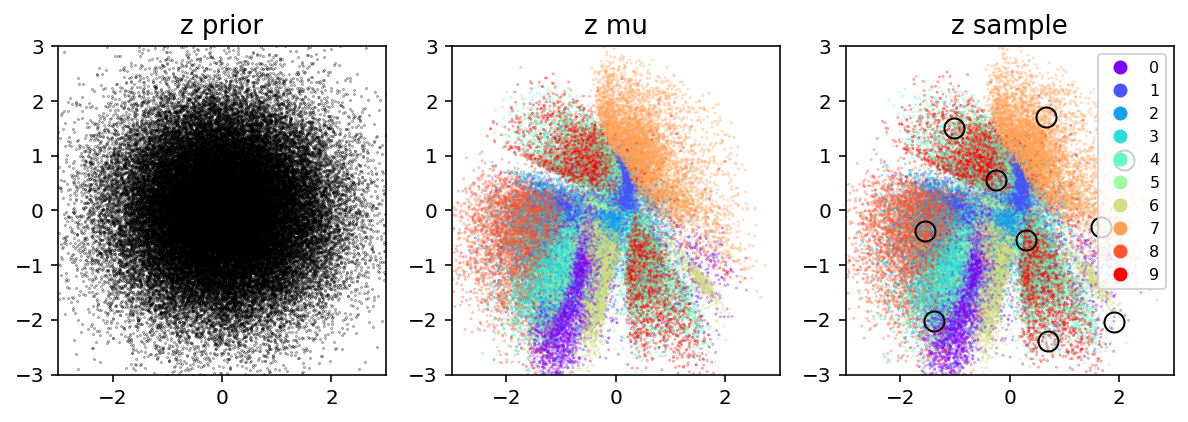

[55/100] total:[1.026] recon:[0.971] kl:[0.056]
[60/100] total:[1.027] recon:[0.966] kl:[0.060]
[65/100] total:[1.026] recon:[0.962] kl:[0.064]
[70/100] total:[1.028] recon:[0.959] kl:[0.069]
[75/100] total:[1.030] recon:[0.956] kl:[0.073]
[80/100] total:[1.031] recon:[0.954] kl:[0.077]
[85/100] total:[1.035] recon:[0.954] kl:[0.081]
[90/100] total:[1.037] recon:[0.952] kl:[0.085]
[95/100] total:[1.039] recon:[0.950] kl:[0.089]


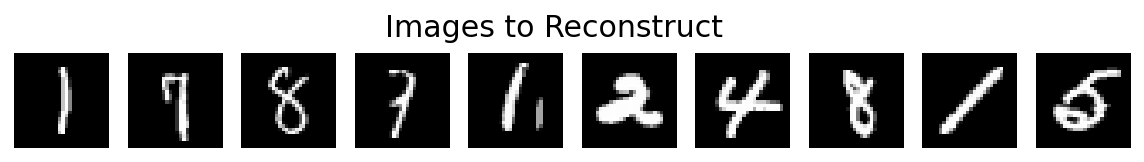

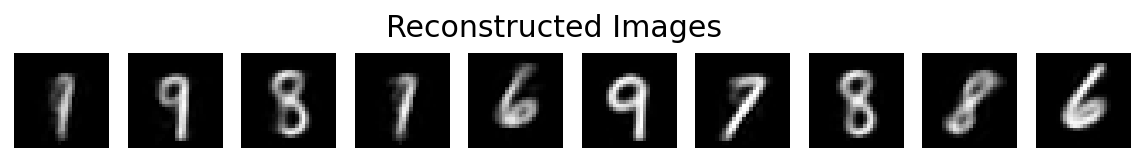

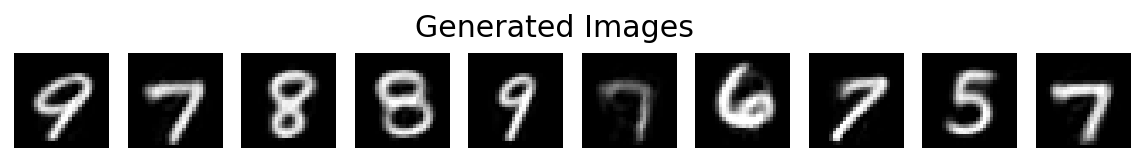

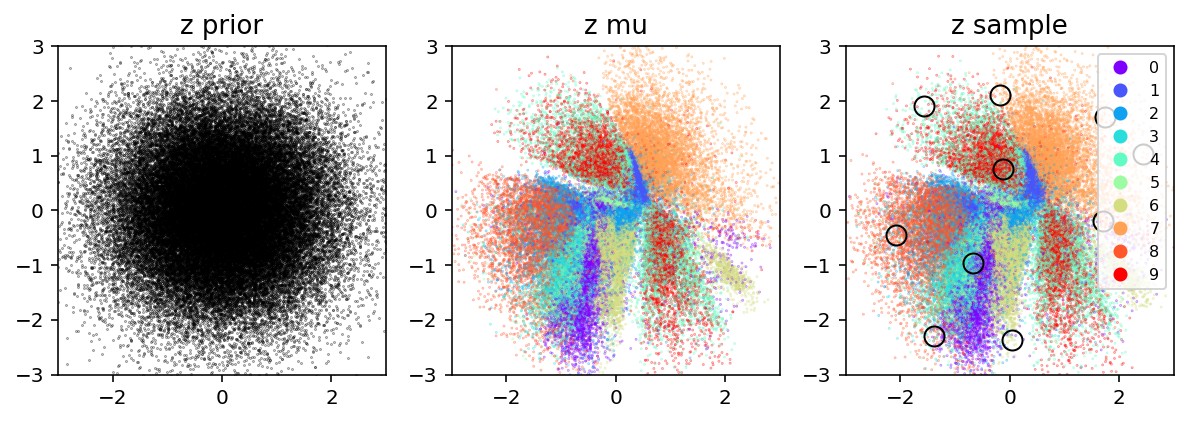

Done.


In [4]:
D = DeepLatentPolicyGradientClass(
    name     = 'DLPG',
    x_dim    = 784,
    c_dim    = 0,
    z_dim    = 2,
    h_dims   = [256,256],
    actv_enc = nn.ReLU(),
    actv_dec = nn.ReLU(),
    actv_q   = nn.Softplus(),
    actv_out = None,
    var_max  = 0.1,
    device   ='cpu',
    )
print ("[%s] instantiated"%(D.name))
# Hyperparameters
n_epoch,print_every,batch_size,plot_every = 100,5,128,50
n_it = (n_train//batch_size) + 1 # number of iterations
optm = torch.optim.Adam(
    params = D.parameters(),
    lr     = 0.001,
    betas  = (0.9,0.99),  # (0.9, 0.999)
    eps    = 1e-4        # 1e-8
)
print (D.parameters)

D.init_params()
dpi = {'x_train_np':x_train_np,'y_train_np':y_train_np,'c_train_np':None,
       'x_test_np':x_test_np,'c_test_np':None,'c_vecs':None,
       'figsize_image':(10,1.25),'figsize_latent':(10,3.25),
       'DPP_GEN':True,'dpp_hyp':{'g':1.0,'l':1.0}}
# D.debug_plot_img(**dpi)
print ("Start training.")
for epoch in range(n_epoch):
    zero_to_one = float(epoch/(n_epoch-1))
    if epoch >= 20: beta = 0.01
    else:           beta = 0.0
    loss_recon_sum,loss_kl_sum,loss_total_sum,n_batch_sum = 0.0,0.0,0.0,0
    rand_idxs = np.random.permutation(n_train)
    for it in range(n_it):
        batch_idx     = rand_idxs[it*batch_size:(it+1)*batch_size]
        x_batch_torch = x_train_torch[batch_idx,:]
        c_batch_torch = None
        q_batch_torch = q_train_torch[batch_idx]
        n_batch       = x_batch_torch.shape[0]
        # Update
        total_loss_out,loss_info = D.loss_total(
            x               = x_batch_torch,
            c               = c_batch_torch,
            q               = q_batch_torch,
            LOSS_TYPE       = 'L1+L2',
            recon_loss_gain = 10.0,
            beta            = beta*zero_to_one,
            STOCHASTICITY   = True)
        optm.zero_grad(); total_loss_out.backward(); optm.step()
        # Errors
        loss_total_sum = loss_total_sum + n_batch*loss_info['loss_total_out']
        loss_recon_sum = loss_recon_sum + n_batch*loss_info['loss_recon_out']
        loss_kl_sum    = loss_kl_sum + n_batch*loss_info['loss_kl_out']
        n_batch_sum    = n_batch_sum + n_batch
    loss_total_avg = loss_total_sum / n_batch_sum
    loss_recon_avg = loss_recon_sum / n_batch_sum
    loss_kl_avg    = loss_kl_sum / n_batch_sum
    
    # Print
    if ((epoch%print_every) == 0):
        print ("[%d/%d] total:[%.3f] recon:[%.3f] kl:[%.3f]"%
               (epoch,n_epoch,loss_total_avg,loss_recon_avg,loss_kl_avg))
    
    # Plot test images
    if ((epoch%plot_every) == 0) or (epoch==(n_epoch-1)):
        D.debug_plot_img(**dpi)
print ("Done.")

### Conditioned DLPG

[DLPG] instantiated
<bound method Module.parameters of DeepLatentPolicyGradientClass(
  (actv_enc): ReLU()
  (actv_dec): ReLU()
  (actv_q): Softplus(beta=1, threshold=20)
  (cvae_parameters): ParameterDict(
      (dec_00_lin_b): Parameter containing: [torch.FloatTensor of size 256]
      (dec_00_lin_w): Parameter containing: [torch.FloatTensor of size 256x12]
      (dec_01_lin_b): Parameter containing: [torch.FloatTensor of size 256]
      (dec_01_lin_w): Parameter containing: [torch.FloatTensor of size 256x256]
      (enc_00_lin_b): Parameter containing: [torch.FloatTensor of size 256]
      (enc_00_lin_w): Parameter containing: [torch.FloatTensor of size 256x794]
      (enc_01_lin_b): Parameter containing: [torch.FloatTensor of size 256]
      (enc_01_lin_w): Parameter containing: [torch.FloatTensor of size 256x256]
      (out_lin_b): Parameter containing: [torch.FloatTensor of size 784]
      (out_lin_w): Parameter containing: [torch.FloatTensor of size 784x256]
      (z_mu_lin_b): 

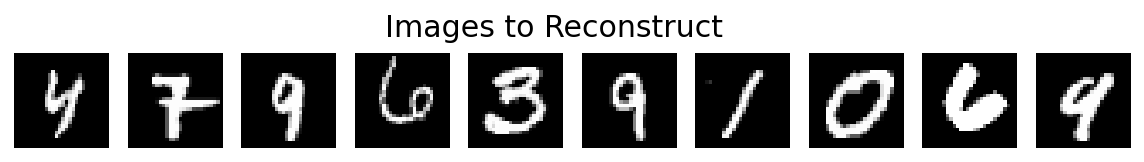

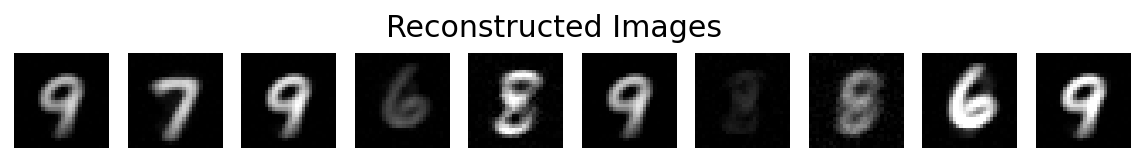

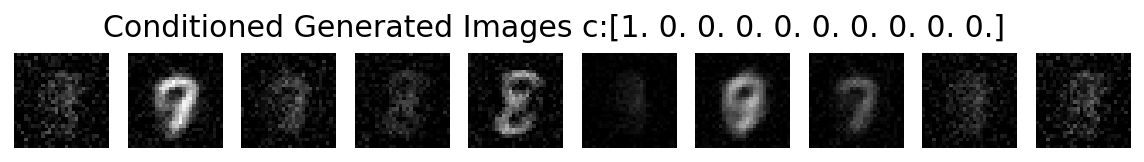

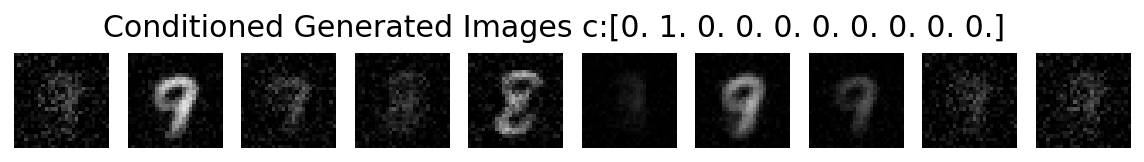

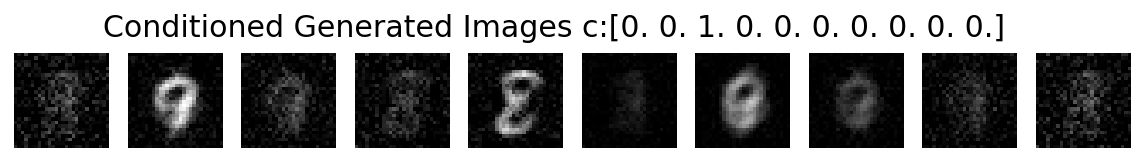

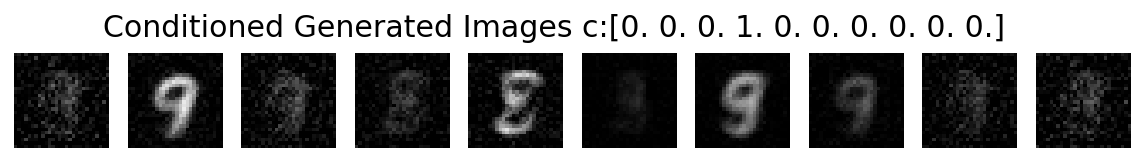

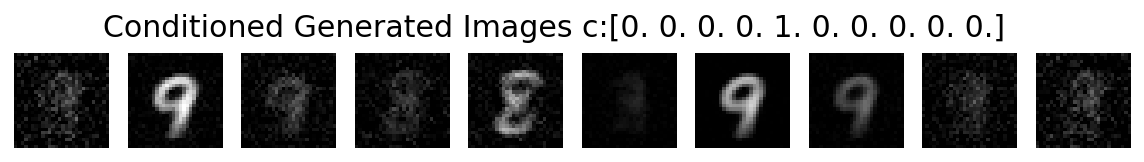

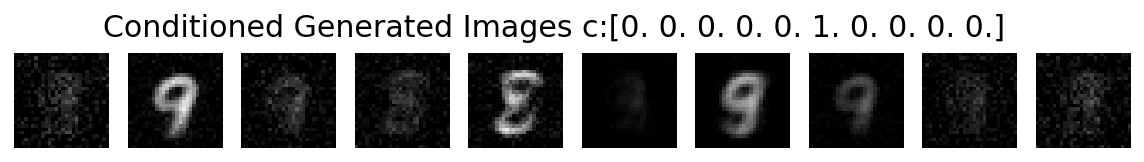

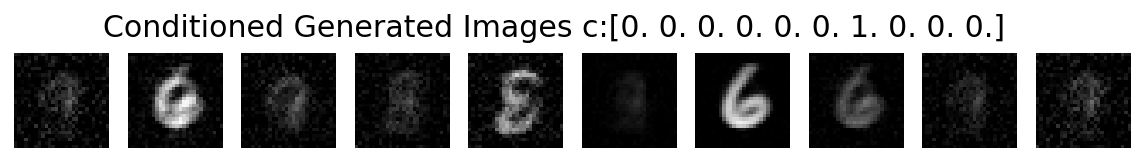

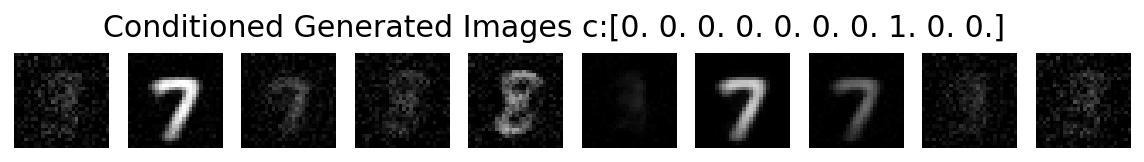

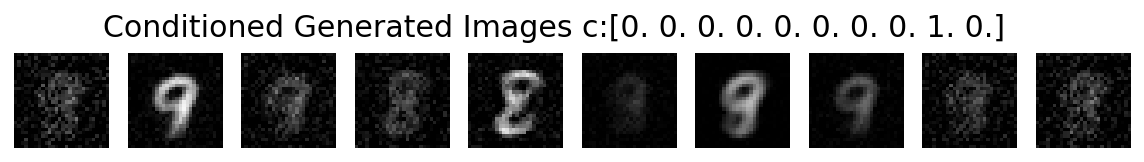

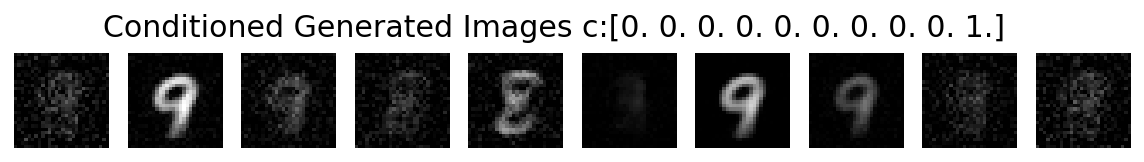

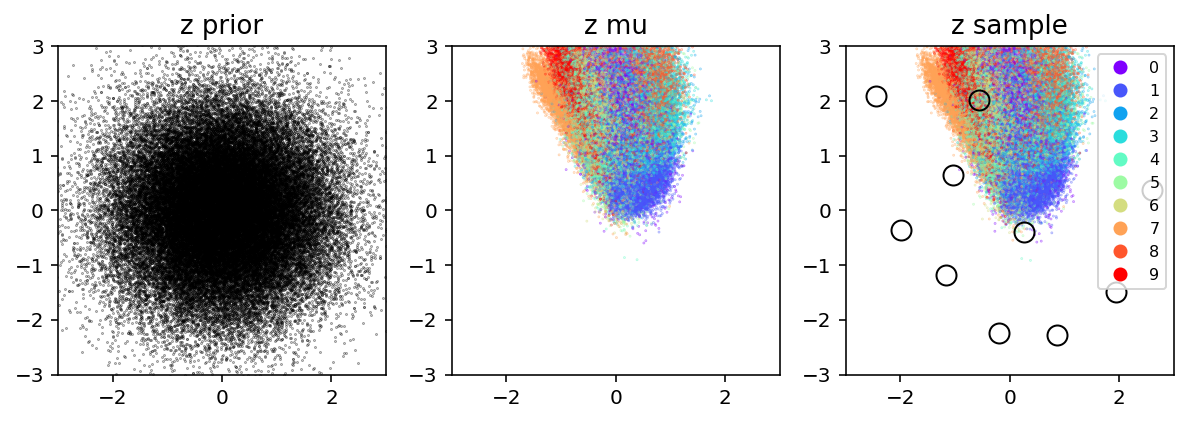

[5/100] total:[1.088] recon:[1.088] kl:[0.000]
[10/100] total:[1.010] recon:[1.010] kl:[0.000]
[15/100] total:[0.968] recon:[0.968] kl:[0.000]
[20/100] total:[0.973] recon:[0.949] kl:[0.024]
[25/100] total:[0.959] recon:[0.935] kl:[0.024]
[30/100] total:[0.952] recon:[0.924] kl:[0.028]
[35/100] total:[0.947] recon:[0.916] kl:[0.031]
[40/100] total:[0.945] recon:[0.911] kl:[0.035]
[45/100] total:[0.944] recon:[0.906] kl:[0.038]
[50/100] total:[0.944] recon:[0.902] kl:[0.042]


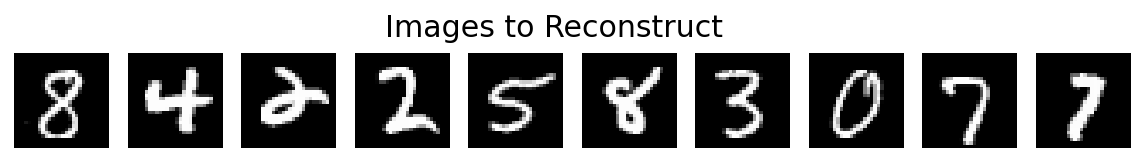

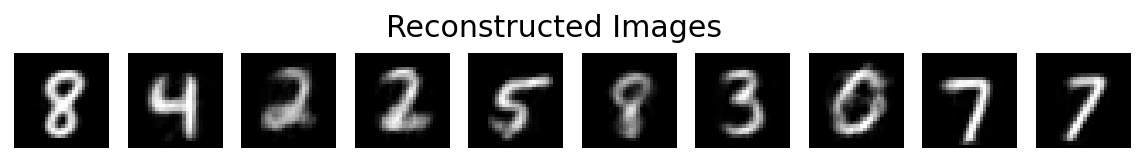

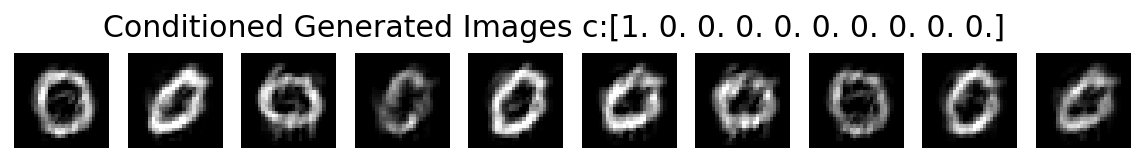

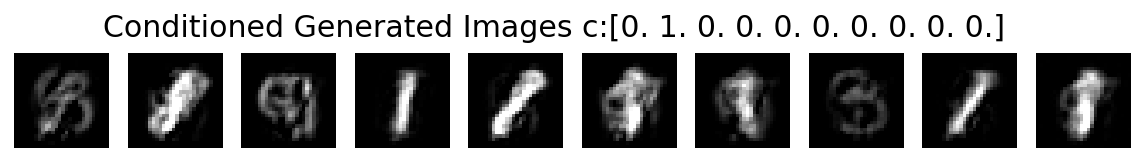

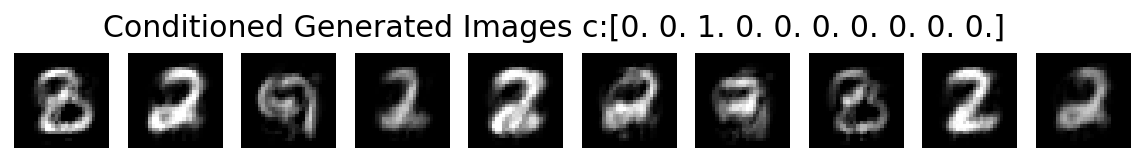

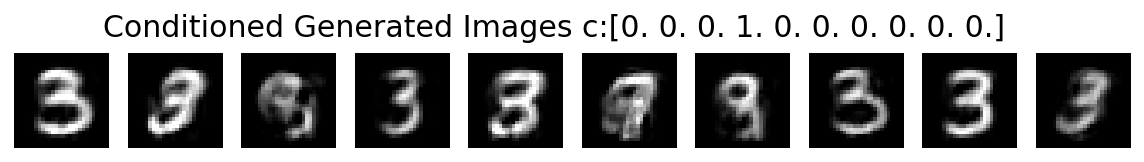

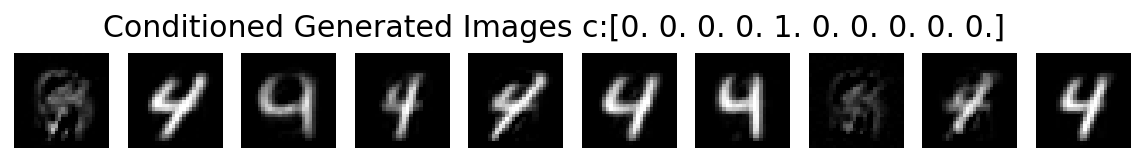

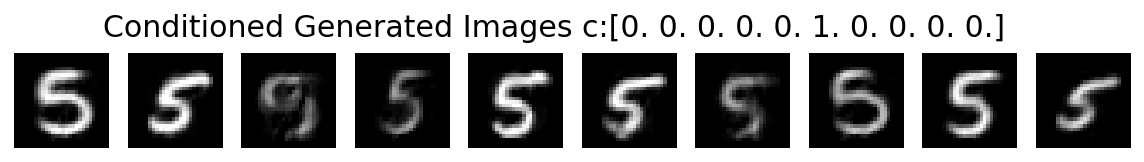

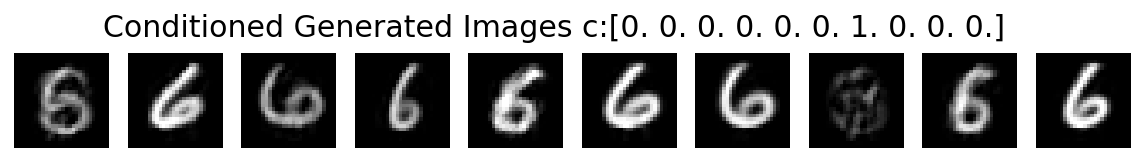

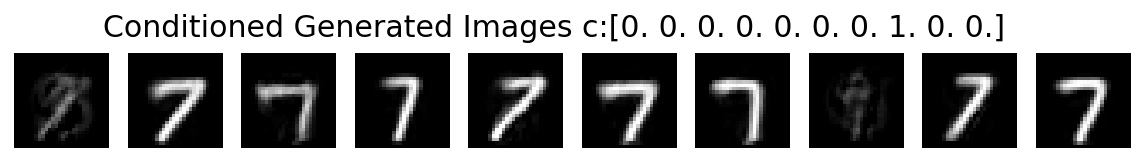

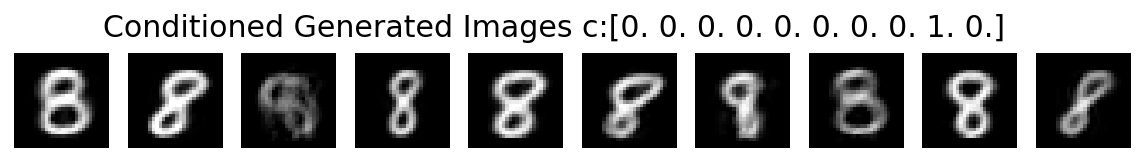

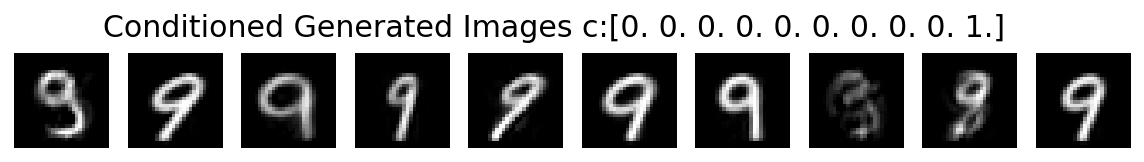

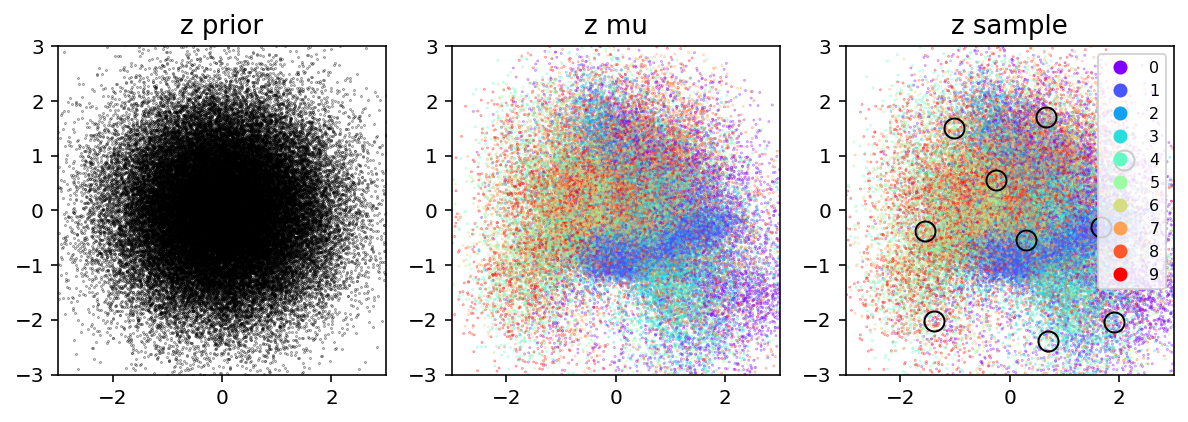

[55/100] total:[0.944] recon:[0.899] kl:[0.045]
[60/100] total:[0.945] recon:[0.897] kl:[0.048]
[65/100] total:[0.947] recon:[0.895] kl:[0.052]
[70/100] total:[0.948] recon:[0.894] kl:[0.055]
[75/100] total:[0.950] recon:[0.892] kl:[0.058]
[80/100] total:[0.952] recon:[0.891] kl:[0.061]
[85/100] total:[0.954] recon:[0.890] kl:[0.064]
[90/100] total:[0.956] recon:[0.890] kl:[0.067]
[95/100] total:[0.958] recon:[0.889] kl:[0.069]


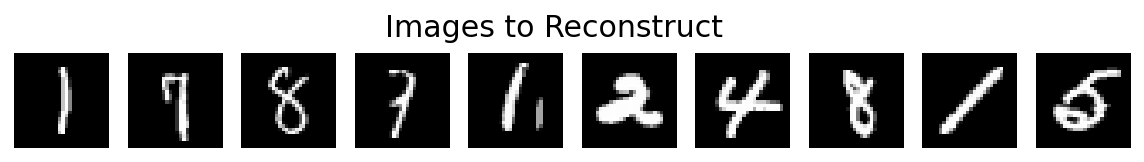

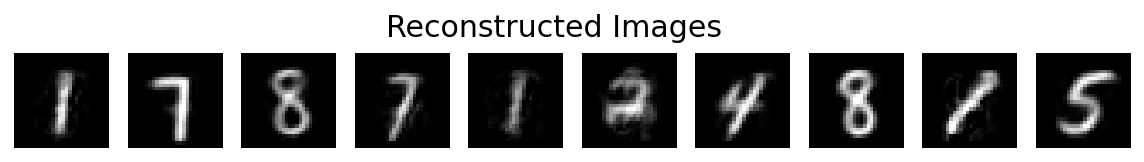

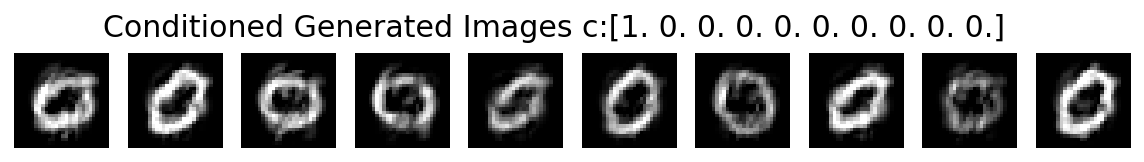

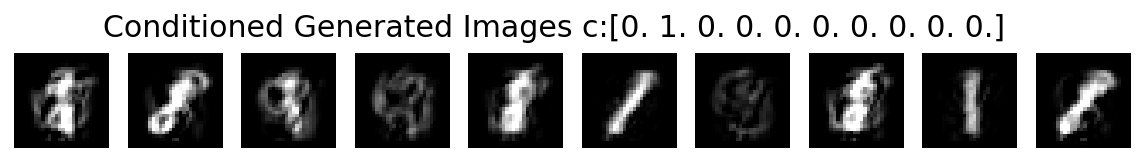

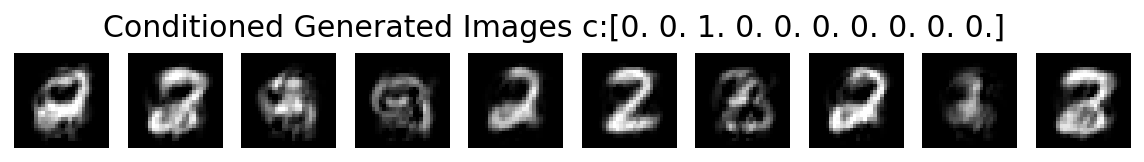

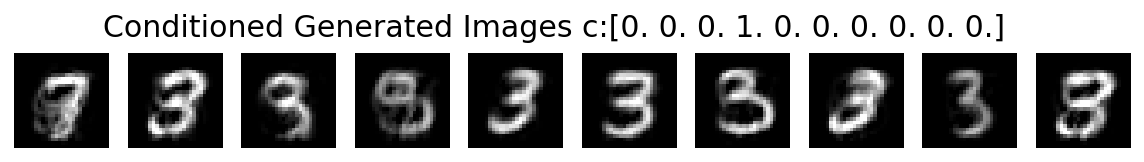

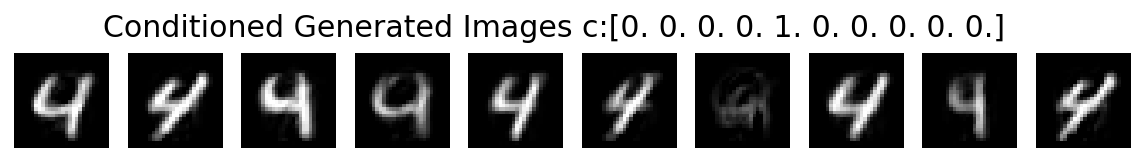

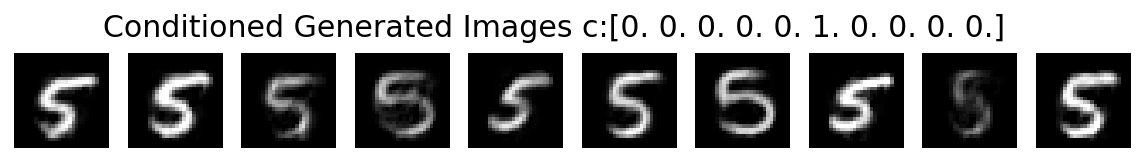

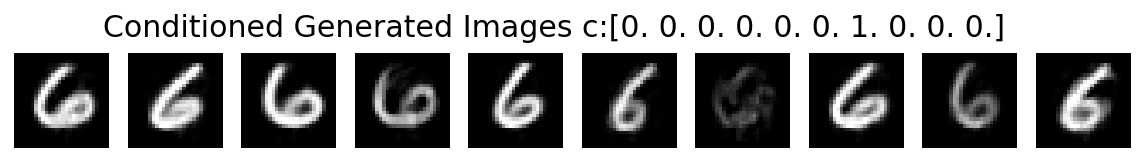

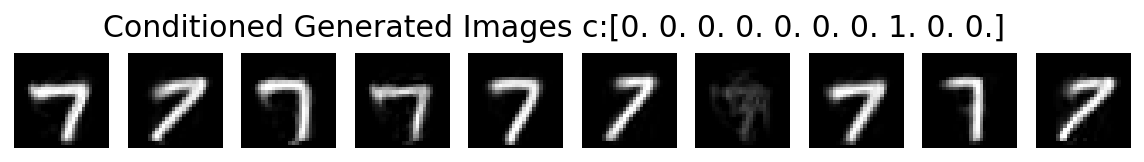

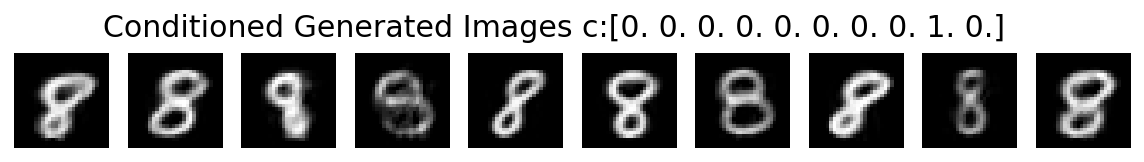

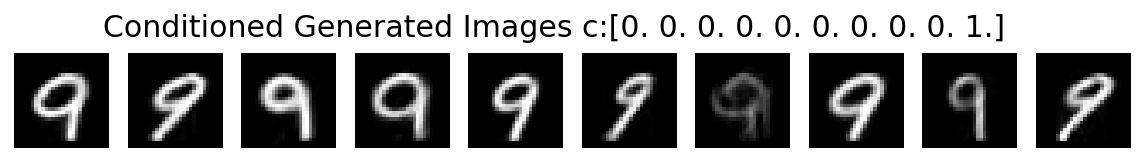

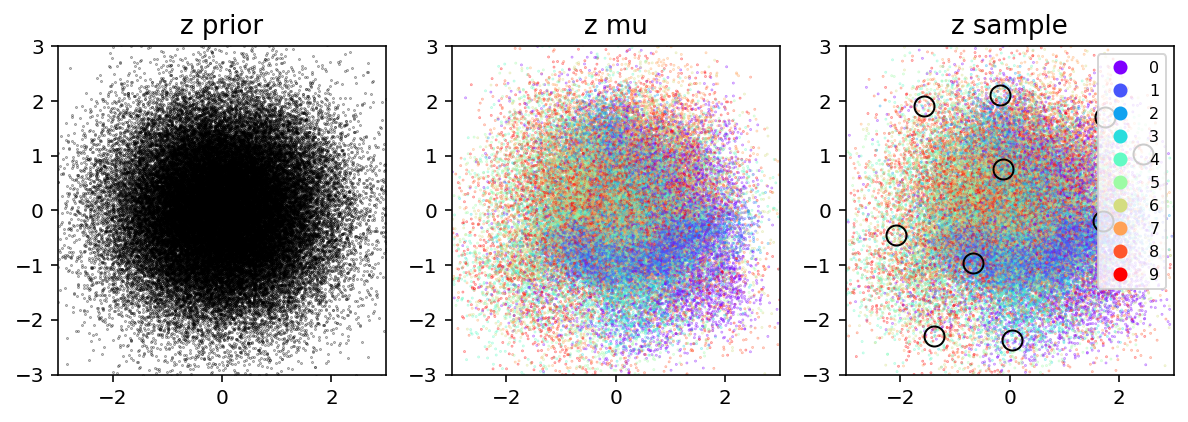

Done.


In [5]:
D = DeepLatentPolicyGradientClass(
    name     = 'DLPG',
    x_dim    = 784,
    c_dim    = 10,
    z_dim    = 2,
    h_dims   = [256,256],
    actv_enc = nn.ReLU(),
    actv_dec = nn.ReLU(),
    actv_q   = nn.Softplus(),
    actv_out = None,
    var_max  = 0.1,
    device   ='cpu',
    )
print ("[%s] instantiated"%(D.name))
# Hyperparameters
n_epoch,print_every,batch_size,plot_every = 100,5,128,50
n_it = (n_train//batch_size) + 1 # number of iterations
optm = torch.optim.Adam(
    params = D.parameters(),
    lr     = 0.001,
    betas  = (0.9,0.99),  # (0.9, 0.999)
    eps    = 1e-4        # 1e-8
) 
print (D.parameters)

D.init_params()
dpi = {'x_train_np':x_train_np,'y_train_np':y_train_np,'c_train_np':c_train_np,
       'x_test_np':x_test_np,'c_test_np':c_test_np,'c_vecs':np.eye(10,10),
       'figsize_image':(10,1.25),'figsize_latent':(10,3.25),
       'DPP_GEN':True,'dpp_hyp':{'g':1.0,'l':1.0}}
# D.debug_plot_img(**dpi)
print ("Start training.")
for epoch in range(n_epoch):
    zero_to_one = float(epoch/(n_epoch-1))
    if epoch >= 20: beta = 0.01
    else:           beta = 0.0
    loss_recon_sum,loss_kl_sum,loss_total_sum,n_batch_sum = 0.0,0.0,0.0,0
    rand_idxs = np.random.permutation(n_train)
    for it in range(n_it):
        batch_idx     = rand_idxs[it*batch_size:(it+1)*batch_size]
        x_batch_torch = x_train_torch[batch_idx,:]
        c_batch_torch = c_train_torch[batch_idx,:]
        q_batch_torch = q_train_torch[batch_idx]
        n_batch       = x_batch_torch.shape[0]
        # Update
        total_loss_out,loss_info = D.loss_total(
            x               = x_batch_torch,
            c               = c_batch_torch,
            q               = q_batch_torch,
            LOSS_TYPE       = 'L1+L2',
            recon_loss_gain = 10.0,
            beta            = beta*zero_to_one,
            STOCHASTICITY   = True)
        optm.zero_grad(); total_loss_out.backward(); optm.step()
        # Errors
        loss_total_sum = loss_total_sum + n_batch*loss_info['loss_total_out']
        loss_recon_sum = loss_recon_sum + n_batch*loss_info['loss_recon_out']
        loss_kl_sum    = loss_kl_sum + n_batch*loss_info['loss_kl_out']
        n_batch_sum    = n_batch_sum + n_batch
    loss_total_avg = loss_total_sum / n_batch_sum
    loss_recon_avg = loss_recon_sum / n_batch_sum
    loss_kl_avg    = loss_kl_sum / n_batch_sum
    
    # Print
    if ((epoch%print_every) == 0):
        print ("[%d/%d] total:[%.3f] recon:[%.3f] kl:[%.3f]"%
               (epoch,n_epoch,loss_total_avg,loss_recon_avg,loss_kl_avg))
    
    # Plot test images
    if ((epoch%plot_every) == 0) or (epoch==(n_epoch-1)):
        D.debug_plot_img(**dpi)
print ("Done.")